# Python Statistics Essential Training

## Hypothesis Test

### 04_01 - Exploring Data

Goals:

* Explore summary statistics by group


In [4]:
import numpy as np
import pandas as pd

url = 'https://github.com/mattharrison/datasets/raw/master/data/ames-housing-dataset.zip'
raw = pd.read_csv(url, engine='pyarrow', dtype_backend='pyarrow')

# Define a function to shrink integer columns to smaller unsigned types if possible
def shrink_ints(df):
    mapping = {}                                                # Initialize a dictionary to store column name and target type mappings
    for col in df.dtypes[df.dtypes == 'int64[pyarrow]'].index:  # Iterate over columns of type 'int64[pyarrow]'
        max_ = df[col].max()                                    # Find the maximum value in the column
        min_ = df[col].min()                                    # Find the minimum value in the column
        if min_ < 0:                                            # Skip columns with negative values (unsigned types can't represent negatives)
            continue
        if max_ < 255:                                          # If the maximum value fits in a uint8 (0-255), map to 'uint8[pyarrow]'
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:                                     # If the maximum value fits in a uint16 (0-65,534), map to 'uint16[pyarrow]'
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4_294_967_295:                              # If the maximum value fits in a uint32 (0-4,294,967,294), map to 'uint32[pyarrow]'
            mapping[col] = 'uint32[pyarrow]'
    return df.astype(mapping)                                   # Convert the DataFrame to the new types according to the mapping

# Define a function to clean the housing data, including handling missing values
def clean_housing_no_na(df):
    return (df
     .assign(**df.select_dtypes('string').replace('', 'Missing').astype('category'),  # Replace empty strings with 'Missing' and convert to categorical
             **{'Garage Yr Blt': df['Garage Yr Blt'].clip(upper=df['Year Built'].max())})  # Clip 'Garage Yr Blt' at the maximum 'Year Built' value
     .pipe(shrink_ints)                                                          # Apply the shrink_ints function to reduce the size of integer columns
     .pipe(lambda df_: df_.assign(**df_.select_dtypes('number').fillna(0)))      # Fill NaN values in numeric columns with 0 <========================
    )    

# Apply the cleaning function to the raw housing data
housing = clean_housing_no_na(raw)

In [5]:
from scipy import stats

housing.Neighborhood.value_counts()  # Count occurrences of each unique value in the 'Neighborhood' column of the housing DataFrame

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

In [6]:
# Group the housing DataFrame by 'Neighborhood', keeping all groups, even if unobserved
(housing
 .groupby('Neighborhood', observed=False)  # Pass 'observed=False' to keep unobserved groups
 .describe()                               # Calculate descriptive statistics for each group
)

Order                                                    \
              count         mean         std     min      25%     50%   
Neighborhood                                                            
Blmngtn        28.0       1500.0  882.971205    53.0   473.75  1742.5   
Blueste        10.0       1187.8   687.00021   299.0   933.25   935.5   
BrDale         30.0  1317.933333  852.662076    30.0   407.25  1045.5   
BrkSide       108.0  1465.037037  778.979802   130.0   742.75  1343.5   
ClearCr        44.0  1551.681818   895.21461   209.0   785.25  1405.0   
CollgCr       267.0  1683.273408  811.009037   250.0    867.5  1477.0   
Crawfor       103.0  1810.679612  778.304759   294.0    938.5  2199.0   
Edwards       194.0  1627.675258  852.935427   235.0   889.25  1502.5   
Gilbert       165.0  1285.254545  815.923617     5.0    479.0  1616.0   
Greens          8.0     1591.375  1131.30417   107.0    459.0  2188.5   
GrnHill         2.0       2575.0  449.719913  2257.0   2416.0  2575.0   
IDOTRR         93.0  1737.784946  798.086201   206.0   1361.0  1559.0   
Landmrk         1.0       2789.0        <NA>  2789.0   2789.0  2789.0   
MeadowV        37.0  1779.243243  959.225452   327.0    978.0  1601.0   
Mitchel       114.0  1707.078947  884.002664   310.0   972.25  1604.5   
NAmes         443.0  1396.733634  847.035881     1.0    636.5  1266.0   
NPkVill        23.0   851.826087  790.536967    33.0    410.5   416.0   
NWAmes        131.0  1245.251908  775.591252    20.0    583.5  1188.0   
NoRidge        71.0   1337.15493  850.279595    60.0    502.5  1158.0   
NridgHt       166.0  1226.819277   789.81649    37.0   447.25  1073.5   
OldTown       239.0  1454.271967  832.683117   159.0    709.5  1314.0   
SWISU          48.0  1496.583333  962.873046   212.0   906.75  1518.5   
Sawyer        151.0  1543.794702  877.468262    84.0    772.5  1398.0   
SawyerW       125.0     1218.232  807.823701    73.0    547.0  1135.0   
Somerst       182.0   1284.60989  780.019717    23.0   527.25  1168.5   
StoneBr        51.0  1326.568627  839.230392     7.0    368.5  1632.0   
Timber         72.0  1721.347222  801.830901   315.0   965.75  1584.5   
Veenker        24.0  1552.291667  636.580913   564.0  1179.75  1828.5   

                                 PID                    ...  Yr Sold          \
                  75%     max  count              mean  ...      75%     max   
Neighborhood                                            ...                    
Blmngtn       2423.25  2430.0   28.0  528228419.642857  ...   2009.0  2010.0   
Blueste       1543.75  2228.0   10.0       909452289.0  ...   2009.0  2010.0   
BrDale        2365.75  2373.0   30.0  527450933.333333  ...   2009.0  2010.0   
BrkSide       2017.25  2688.0  108.0  848613471.342593  ...   2009.0  2010.0   
ClearCr       2118.25  2768.0   44.0  905484400.659091  ...   2009.0  2010.0   
CollgCr        2160.5  2816.0  267.0  907085271.310861  ...   2009.0  2010.0   
Crawfor        2226.0  2885.0  103.0  909524049.524272  ...   2009.0  2010.0   
Edwards       2188.75  2845.0  194.0  907121611.597938  ...   2009.0  2010.0   
Gilbert        1757.0  2442.0  165.0  527756053.090909  ...   2009.0  2010.0   
Greens        2520.25  2522.0    8.0      533253106.25  ...  2009.25  2010.0   
GrnHill        2734.0  2893.0    2.0       916252745.0  ...  2006.75  2007.0   
IDOTRR         2242.0  2883.0   93.0   908603183.44086  ...   2008.0  2010.0   
Landmrk        2789.0  2789.0    1.0       907230240.0  ...   2006.0  2006.0   
MeadowV        2909.0  2921.0   37.0  923226785.405405  ...   2009.0  2010.0   
Mitchel       2299.75  2930.0  114.0  920606212.903509  ...   2009.0  2010.0   
NAmes          1961.5  2635.0  443.0  533841585.564334  ...   2009.0  2010.0   
NPkVill        1365.0  2378.0   23.0  527453576.086957  ...   2009.0  2010.0   
NWAmes         1866.5  2541.0  131.0  530362950.038168  ...   2009.0  2010.0   
NoRidge        1833.5  2504.0   71.0  529225388.732394  ...   2009.0  

In [7]:
# Group the housing DataFrame by 'Neighborhood', calculate descriptive statistics,
# and then filter the results to show statistics for 'CollgCr' and 'NAmes' neighborhoods, specifically for the 'SalePrice' column.
(housing
 .groupby('Neighborhood', observed=False)   # Group the data by the 'Neighborhood' column
 .describe()                                # Generate descriptive statistics for each neighborhood group
 .loc[['CollgCr', 'NAmes'], ['SalePrice']]  # Select the 'SalePrice' column for the neighborhoods 'CollgCr' and 'NAmes'
)


SalePrice                                                   \
                 count           mean           std       min       25%   
Neighborhood                                                              
CollgCr          267.0  201803.434457  54187.843749  110000.0  160875.0   
NAmes            443.0  145097.349887  31882.707229   68000.0  127000.0   

                                            
                   50%       75%       max  
Neighborhood                                
CollgCr       200000.0  228250.0  475000.0  
NAmes         140000.0  157500.0  345000.0

In [8]:
# Group the housing DataFrame by 'Neighborhood', calculate descriptive statistics,
# filter the results for 'CollgCr' and 'NAmes' neighborhoods for 'SalePrice',
# and transpose the DataFrame for better readability
(housing
 .groupby('Neighborhood', observed=False)   # Group the data by the 'Neighborhood' column
 .describe()                                # Generate descriptive statistics for each neighborhood group
 .loc[['CollgCr', 'NAmes'], ['SalePrice']]  # Select the 'SalePrice' column for the neighborhoods 'CollgCr' and 'NAmes'
 .T                                         # Transpose the DataFrame so that rows and columns are swapped (makes it easier to compare stats)
)

Neighborhood           CollgCr          NAmes
SalePrice count          267.0          443.0
          mean   201803.434457  145097.349887
          std     54187.843749   31882.707229
          min         110000.0        68000.0
          25%         160875.0       127000.0
          50%         200000.0       140000.0
          75%         228250.0       157500.0
          max         475000.0       345000.0

### 04_02 - Visualizing Distributions

Goals

* Make histograms of both distributions
* Make a cumulative distribution plot

In [10]:
# Extract SalePrice data for the 'NAmes' neighborhood
n_ames = (housing
          .query('Neighborhood == "NAmes"')  # Filter rows where 'Neighborhood' is 'NAmes'
          .SalePrice)                        # Select the 'SalePrice' column

# Extract SalePrice data for the 'CollgCr' neighborhood
college_cr = (housing
              .query('Neighborhood == "CollgCr"')  # Filter rows where 'Neighborhood' is 'CollgCr'
              .SalePrice)                          # Select the 'SalePrice' column

In [11]:
n_ames

0       215000
1       105000
2       172000
3       244000
23      149000
         ...  
2630    155000
2631    134500
2632    120000
2633    105000
2634    124000
Name: SalePrice, Length: 443, dtype: uint32[pyarrow]

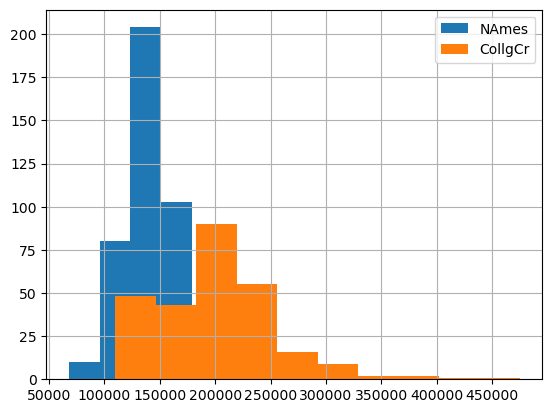

In [12]:
# Create histograms for 'NAmes' and 'CollgCr' neighborhoods on the same plot

ax = n_ames.hist(label='NAmes')          # Create a histogram for 'NAmes' SalePrice data and set the label for the legend
college_cr.hist(ax=ax, label='CollgCr')  # Overlay the histogram for 'CollgCr' SalePrice data on the same plot (using the same ax)
ax.legend();                             # Add a legend to distinguish the two histograms

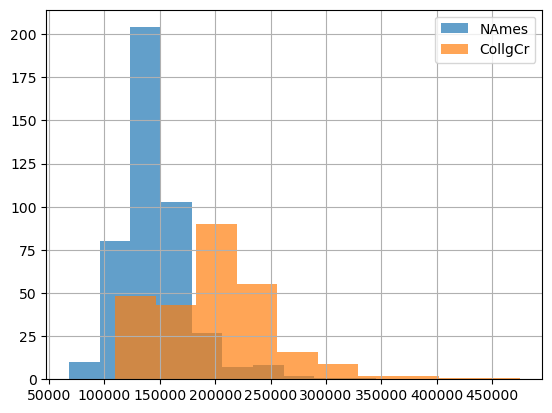

In [13]:
# Create overlaid histograms for 'NAmes' and 'CollgCr' neighborhoods with transparency

alpha = .7                                            # Set the transparency level for the histograms

ax = n_ames.hist(label='NAmes', alpha=alpha)          # Create a histogram for 'NAmes' with the specified transparency
college_cr.hist(ax=ax, label='CollgCr', alpha=alpha)  # Overlay the 'CollgCr' histogram on the same plot, using the same transparency
ax.legend();                                          # Add a legend to distinguish between 'NAmes' and 'CollgCr'

In [14]:
# Create the CDF (Cumulative Distribution Function) for 'NAmes' SalePrice data

(n_ames
 .to_frame()                                           # Convert the Series (n_ames) to a DataFrame for easier manipulation
 .assign(cdf=n_ames.rank(method='average', pct=True))  # Create a new column 'cdf' for the CDF (ranked SalePrice as a percentage)
 .sort_values(by='SalePrice')                          # Sort the DataFrame by 'SalePrice' for proper plotting of the CDF
)

,SalePrice,cdf
2598,68000,0.002257
397,76500,0.004515
2624,81400,0.006772
125,84900,0.009029
2625,87500,0.011287
...,...,...
625,256000,0.990971
1614,268000,0.993228
2617,277500,0.995485
1945,301600,0.997743


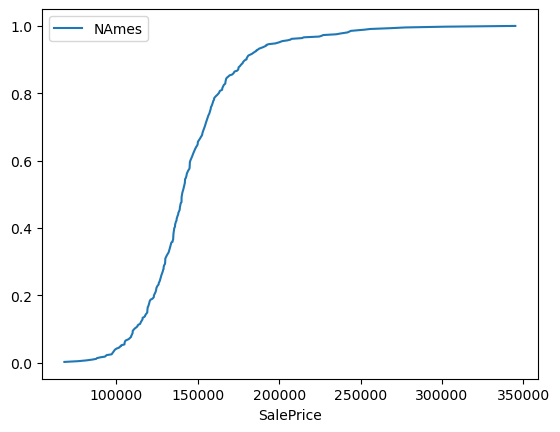

In [15]:
# Plot the CDF (Cumulative Distribution Function) for 'NAmes' SalePrice data

(n_ames
 .to_frame()                                           # Convert the Series (n_ames) to a DataFrame for easier manipulation
 .assign(cdf=n_ames.rank(method='average', pct=True))  # Create a new column 'cdf' for the CDF (ranked SalePrice as a percentage)
 .sort_values(by='SalePrice')                          # Sort the DataFrame by 'SalePrice' for proper plotting of the CDF
 .plot(x='SalePrice', y='cdf', label='NAmes')          # Plot SalePrice vs CDF with 'SalePrice' on the x-axis and 'cdf' on the y-axis
);

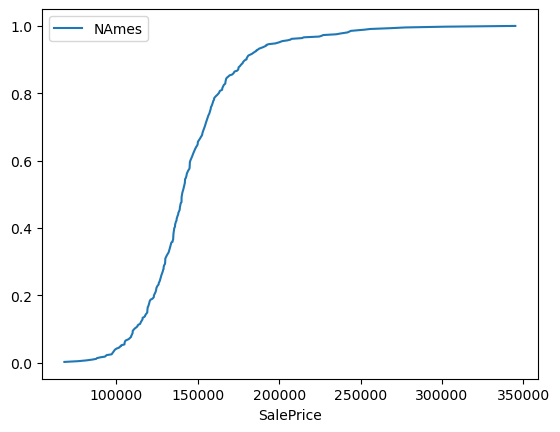

In [16]:
# Define the function to plot the CDF of a Series
def plot_cdf(ser, ax=None, label=''):  
    (ser
     .to_frame()                                        # Convert the Series to a DataFrame for easier manipulation
     .assign(cdf=ser.rank(method='average', pct=True))  # Create a 'cdf' column with the cumulative distribution function (as percentages)
     .sort_values(by='SalePrice')                       # Sort the DataFrame by 'SalePrice' for proper plotting of the CDF
     .plot(x='SalePrice', y='cdf', label=label, ax=ax)  # Plot 'SalePrice' vs 'cdf' with optional 'ax' for custom axes and a label
    )
    return ser                                          # Return the original Series

# Plot the CDF for 'n_ames', labeling it as 'NAmes'
plot_cdf(n_ames, label='NAmes');

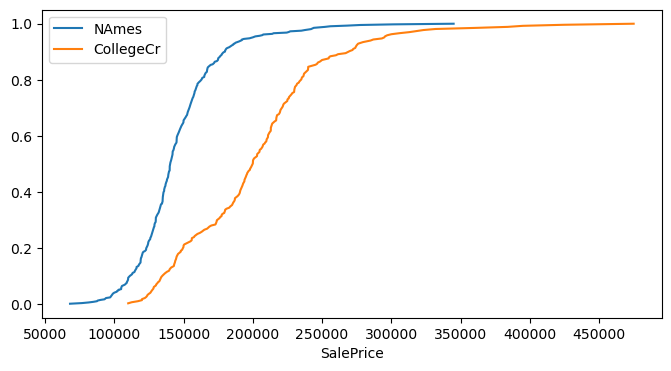

In [17]:
from matplotlib import pyplot as plt

# Define the function to plot the CDF of a Series
def plot_cdf(ser, ax=None, label=''):
    (ser
     .to_frame()                                        # Convert the Series to a DataFrame for easier manipulation
     .assign(cdf=ser.rank(method='average', pct=True))  # Create a 'cdf' column with the cumulative distribution function (as percentages)
     .sort_values(by='SalePrice')                       # Sort the DataFrame by 'SalePrice' for proper plotting of the CDF
     .plot(x='SalePrice', y='cdf', label=label, ax=ax)  # Plot 'SalePrice' vs 'cdf' with optional 'ax' for custom axes and a label
    )
    return ser                                          # Return the original Series

# Create a figure with custom size and plot CDFs for both neighborhoods
fig, ax = plt.subplots(figsize=(8,4))                   # Create a figure and axis with specified dimensions
plot_cdf(n_ames, label='NAmes', ax=ax)                  # Plot CDF for 'NAmes' neighborhood on the provided axis
plot_cdf(college_cr, label='CollegeCr', ax=ax);         # Plot CDF for 'CollegeCr' neighborhood on the same axis

For these two neighborhoods that we're looking at, these don't appear to overlap, suggesting that they are not the same distribution.

### 04_03 - Running Statistical Tests

Goals:

* Use the `scipy.stats` module to run a statistical test

In [20]:
#print(dir(stats))

In [21]:
#stats.ks_2samp?

In [22]:
# Perform the Kolmogorov-Smirnov test for comparing two samples
ks_statistic, p_value = stats.ks_2samp(n_ames, college_cr)  # Compute the KS statistic and p-value for the two samples (n_ames and college_cr)
print(ks_statistic, p_value)                                # Output the KS statistic and the corresponding p-value

0.5836609430085982 3.2892428354379855e-53


In [23]:
# Conditional check based on the p-value from the KS test

if p_value > 0.05:          # If p_value is greater than 0.05, there's no significant difference between the distributions
    print('Fail to reject null hypothesis: Same distribution')
else:                       # If p_value is 0.05 or less, there's a significant difference between the distributions
    print('Reject null hypothesis: Not from the same distribution')  

Reject null hypothesis: Not from the same distribution


### 04_04 - Testing for Normality

Goals:

* Use the `scipy.stats` module to test for normality
* Use the `scipy.stats` module to create a probability plot

In [25]:
# Use the Shapiro-Wilk test to check for normality in the 'n_ames' sample
shapiro_stat, p_value = stats.shapiro(n_ames)  # Perform the Shapiro-Wilk test to check if the 'n_ames' SalePrice data follows a normal distribution

In [26]:
# Conditional check based on the p-value from the Shapiro-Wilk test

if p_value > 0.05:       # If p_value is greater than 0.05, there's no significant deviation from normality
    print("The distribution of the series is likely normal (fail to reject H0)")  
else:                    # If p_value is 0.05 or less, there's significant evidence that the distribution is not normal
    print("The distribution of the series is likely not normal (reject H0)")  

The distribution of the series is likely not normal (reject H0)


In [27]:
p_value

5.124374299470901e-17

In [28]:
#stats.probplot?

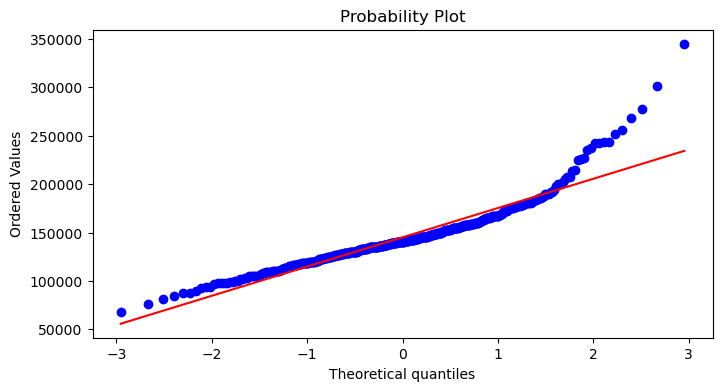

In [29]:
import matplotlib.pyplot as plt

# Create a probability plot to visually check for normality in 'n_ames' data

fig, ax = plt.subplots(figsize=(8,4))  # Create a figure and axis with specified dimensions for the plot

_ = stats.probplot(n_ames, plot=ax)    # Generate a Q-Q (quantile-quantile) plot for 'n_ames' and plot it on the provided axis

This is a visual interpretation: We would like to see the blue dots track that red line, and if they do track that red line, that would be a strong indication that this is normal. You can see that it looks like it's overlapping the red line at a few points, but it's a little bit above on the small end. Then it goes below the red line and then it goes back up above the red line. From looking at this probability plot, I would say that this is not normal. It's close to normal on the left hand side, but on the right hand side it is not.

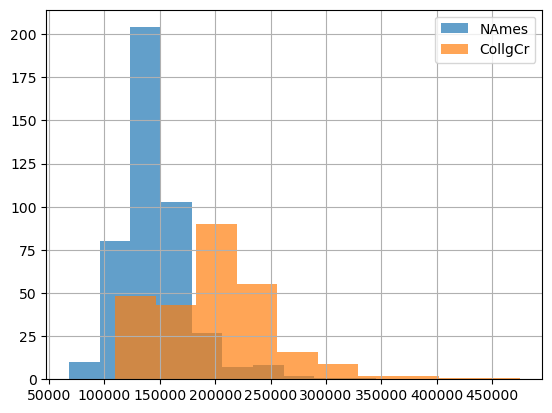

In [31]:
alpha = .7                                            # Set transparency level for the histograms
ax = n_ames.hist(label='NAmes', alpha=alpha)          # Create a histogram for 'NAmes' SalePrice data with specified transparency and label
college_cr.hist(ax=ax, label='CollgCr', alpha=alpha)  # Overlay the histogram for 'CollgCr' SalePrice data on the same axis with the same transparency
ax.legend();                                          # Add a legend to distinguish between 'NAmes' and 'CollgCr'

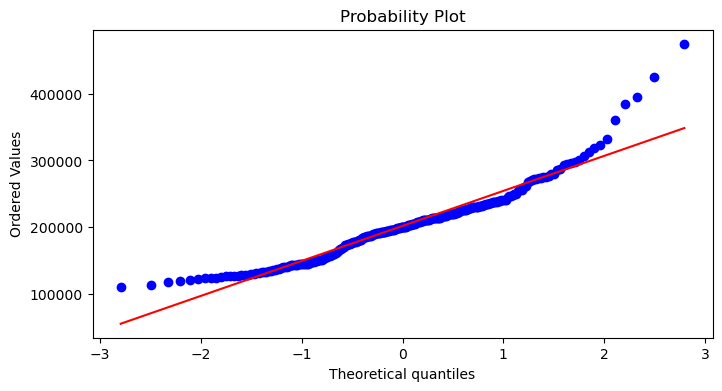

In [32]:
import matplotlib.pyplot as plt

# Create a probability plot to visually check for normality in 'college_cr' data

fig, ax = plt.subplots(figsize=(8,4))  # Create a figure and axis with specified dimensions for the plot

_ = stats.probplot(college_cr, plot=ax)  # Generate a Q-Q plot for 'college_cr' and plot it on the provided axis

### 04_05 - Challenge: Checking Square Footage Distributions
* Is the distribution of *1st Flr SF* from *NAmes* and *CollgCr* the same?

In [34]:
# Extract '1st FlrSF' data for the 'NAmes' neighborhood
n_ames_sf = (housing
          .query('Neighborhood == "NAmes"')   # Filter rows where 'Neighborhood' is 'NAmes'
          .loc[:, '1st Flr SF']               # Create a series here with '1st Flr SF'
             )

# Extract '1st FlrSF' data for the 'CollgCr' neighborhood
college_cr_sf = (housing
              .query('Neighborhood == "CollgCr"')  # Filter rows where 'Neighborhood' is 'CollgCr'
              .loc[:, '1st Flr SF']                # Create a series here with '1st Flr SF'
                 )

In [35]:
n_ames_sf

0       1656
1        896
2       1329
3       2110
23      1004
        ... 
2630     660
2631     999
2632    1045
2633     864
2634    1025
Name: 1st Flr SF, Length: 443, dtype: uint16[pyarrow]

Now I have my two datasets here. I want to see if these distributions are the same.

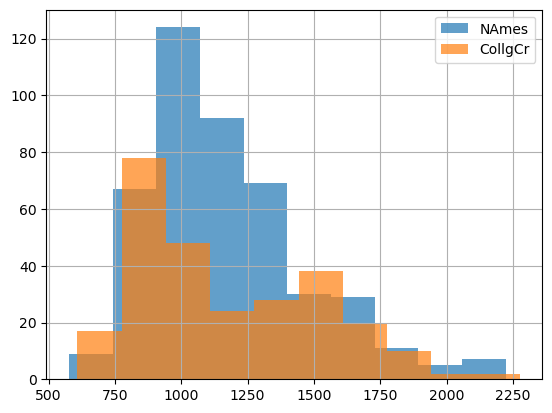

In [37]:
alpha = .7                                               # Set transparency level for the histograms
ax = n_ames_sf.hist(label='NAmes', alpha=alpha)          # Create a histogram for 'NAmes' '1st FlrSF' data 
college_cr_sf.hist(ax=ax, label='CollgCr', alpha=alpha)  # Overlay the histogram for 'CollgCr' '1st FlrSF' data 
ax.legend();                                             # Add a legend to distinguish between 'NAmes' and 'CollgCr'

These do not look like the same distribution but let's quantify that using our summary statistics.

In [39]:
# Perform the Kolmogorov-Smirnov test for comparing two samples
ks_statistic, p_value = stats.ks_2samp(n_ames_sf, college_cr_sf)  # Compute the KS statistic and p-value for the two samples
print(ks_statistic, p_value)                                      # Output the KS statistic and the corresponding p-value

0.15300851362433526 0.0007057410997705426


In [40]:
# Conditional check based on the p-value from the KS test

if p_value > 0.05:          # If p_value is greater than 0.05, there's no significant difference between the distributions
    print('Fail to reject null hypothesis: Same distribution')
else:                       # If p_value is 0.05 or less, there's a significant difference between the distributions
    print('Reject null hypothesis: Not from the same distribution')  

Reject null hypothesis: Not from the same distribution
